In [1]:
import os
os.chdir('./../..')
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets.ascad_datasets import AscadDataset
from models.cnn import BenadjilaBest

In [2]:
shuffle = True
batch_size = 256

model = BenadjilaBest((1, 700), (256,))
print(model)

train_dataset = AscadDataset(train=True)
test_dataset = AscadDataset(train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
loss_fn = nn.CrossEntropyLoss()

BenadjilaBest(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): BatchNorm1d(512, e

In [3]:
num_epochs = 150
from training.common import mean_rank

train_loss_vals = {}
train_acc_vals = {}
train_rank_vals = {}
val_loss_vals = {}
val_acc_vals = {}
val_rank_vals = {}

def to_np(x):
    return x.detach().cpu().numpy()
def acc(logits, labels):
    preds = np.argmax(to_np(logits), axis=-1)
    labels = to_np(labels)
    acc = np.mean(np.equal(preds, labels))
    return acc

dropout_vals = [0, 0.1, 0.2, 0.3, 0.4]
lr_vals = [5e-6, 1e-5, 5e-5]

for dropout_val in dropout_vals:
    for lr_val in lr_vals:
        model = BenadjilaBest(input_shape=train_dataset.trace_shape,
                              output_shape=(train_dataset.num_classes,),
                              dropout=dropout_val).cuda()
        optimizer = optim.RMSprop(model.parameters(), lr=lr_val)
        
        key = (dropout_val, lr_val)
        train_loss_vals[key] = []
        train_acc_vals[key] = []
        train_rank_vals[key] = []
        val_loss_vals[key] = []
        val_acc_vals[key] = []
        val_rank_vals[key] = []
        
        for epoch in tqdm(range(num_epochs)):
            model.train()
            for batch in train_dataloader:
                trace, label = batch
                trace = trace.cuda()
                label = label.cuda()
                logits = model(trace)
                loss = loss_fn(logits, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss_vals[key].append(to_np(loss))
                train_acc_vals[key].append(acc(logits, label))
                train_rank_vals[key].append(mean_rank(logits, label))
            model.eval()
            with torch.no_grad():
                for batch in test_dataloader:
                    trace, label = batch
                    trace = trace.cuda()
                    label = label.cuda()
                    logits = model(trace)
                    loss = loss_fn(logits, label)
                    val_loss_vals[key].append(to_np(loss))
                    val_acc_vals[key].append(acc(logits, label))
                    val_rank_vals[key].append(mean_rank(logits, label))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [1:58:36<00:00, 47.44s/it]


In [40]:
import pickle
results_dir = os.path.join('.', 'results', 'classifier_training')
with open(os.path.join(results_dir, 'data.pickle'), 'wb') as F:
    pickle.dump({'train_loss': train_loss_vals,
                 'val_loss': val_loss_vals,
                 'train_acc': train_acc_vals,
                 'val_acc': val_acc_vals,
                 'train_rank': train_rank_vals,
                 'val_rank': val_rank_vals}, F)

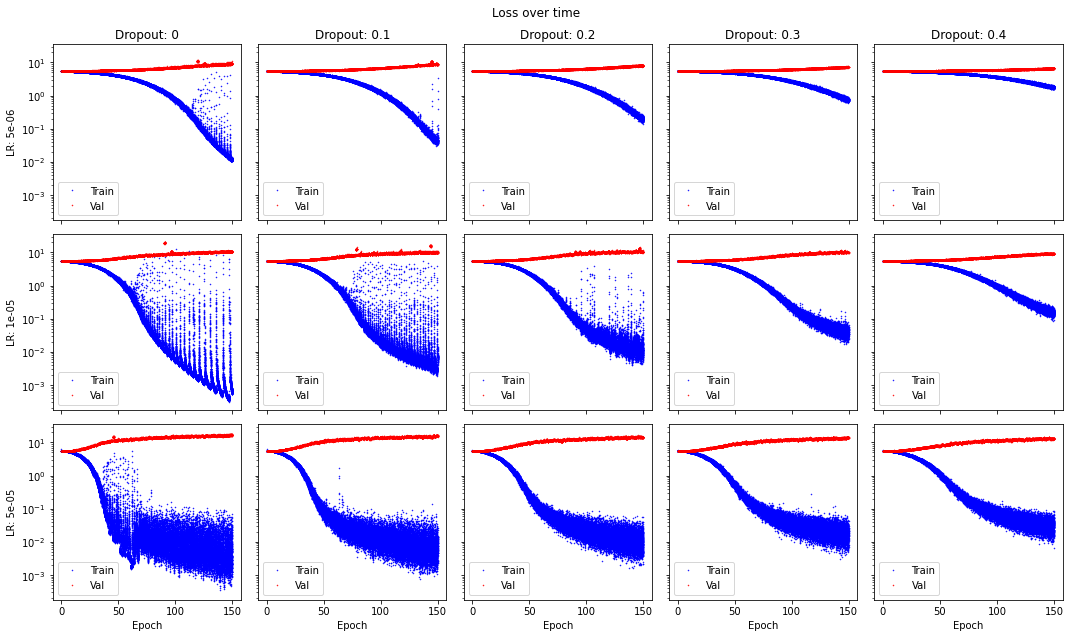

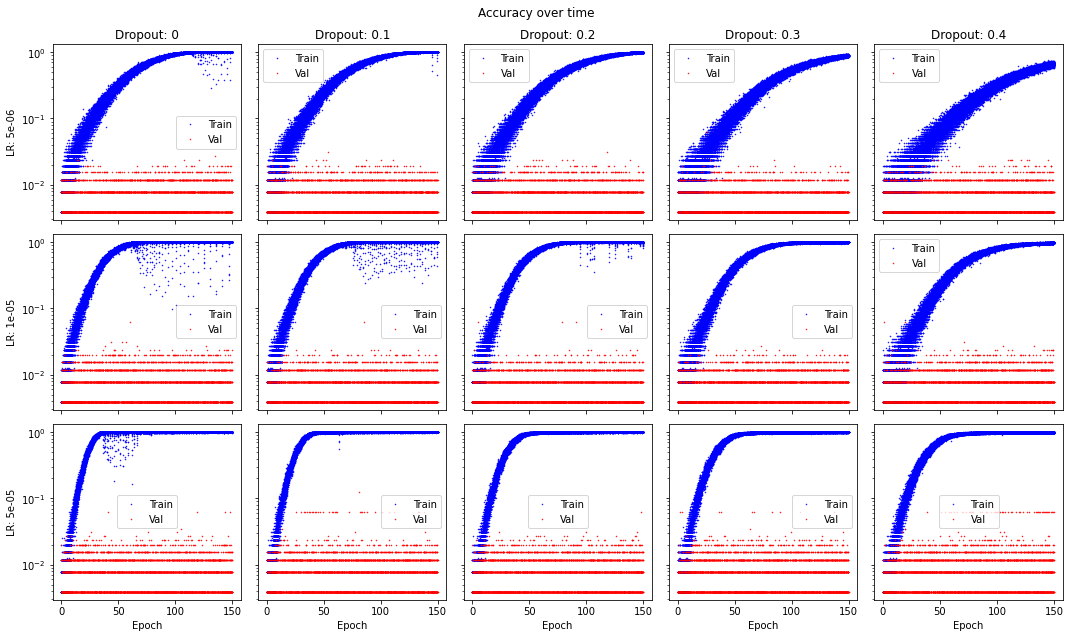

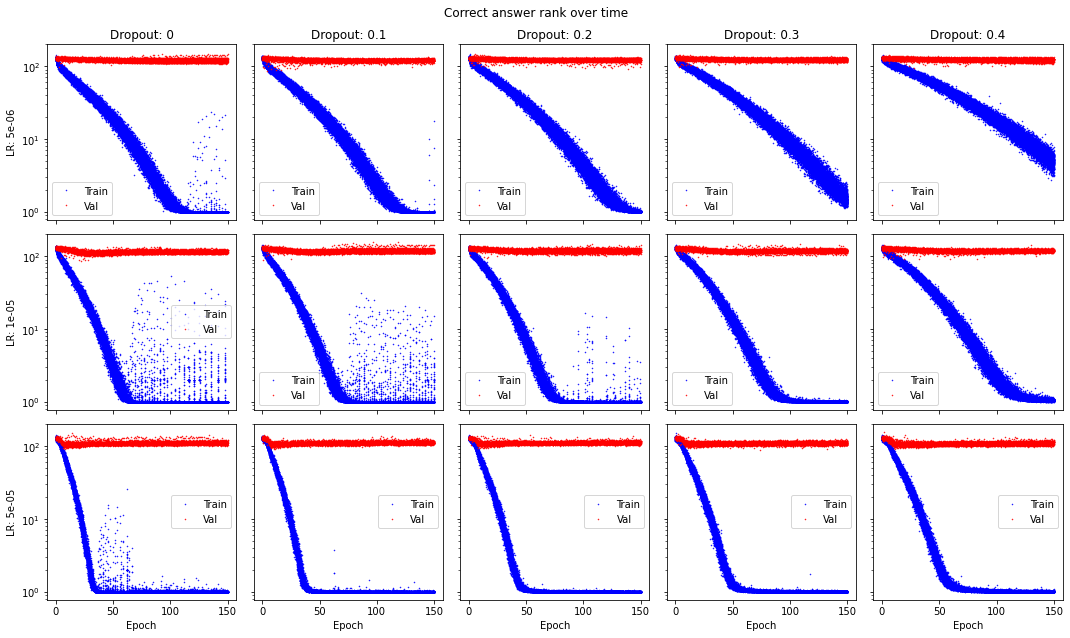

In [41]:
def local_avg(trace, length):
    return np.array([np.mean(trace[i*length:(i+1)*length]) for i in range(len(trace)//length)])

def plot_vals(train_vals_dict, val_vals_dict, title):
    (fig, axes) = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(15, 9))
    for yidx, dropout_val in enumerate(dropout_vals):
        for xidx, lr_val in enumerate(lr_vals):
            train_vals = train_vals_dict[(dropout_val, lr_val)]
            train_epochs = np.linspace(0, num_epochs, len(train_vals))
            val_vals = val_vals_dict[(dropout_val, lr_val)]
            val_epochs = np.linspace(0, num_epochs, len(val_vals))
            ax = axes[xidx][yidx]
            ax.plot(train_epochs, train_vals, '.', markersize=1, color='blue', label='Train')
            ax.plot(val_epochs, val_vals, '.', markersize=1, color='red', label='Val')
            ax.set_yscale('log')
            ax.legend()
    fig.suptitle(title)
    for ax, dropout_val in zip(axes[0, :], dropout_vals):
        ax.set_title('Dropout: {}'.format(dropout_val))
    for ax, lr_val in zip(axes[:, 0], lr_vals):
        ax.set_ylabel('LR: {}'.format(lr_val))
    for ax in axes[-1, :]:
        ax.set_xlabel('Epoch')
    plt.tight_layout()
    fig.savefig(os.path.join(results_dir, 'perf_over_time__%s.png'%(title.split(' ')[0])))

plot_vals(train_loss_vals, val_loss_vals, 'Loss over time')
plot_vals(train_acc_vals, val_acc_vals, 'Accuracy over time')
plot_vals(train_rank_vals, val_rank_vals, 'Correct answer rank over time')

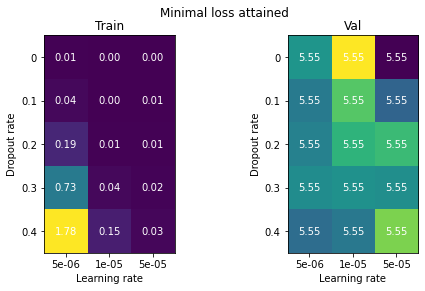

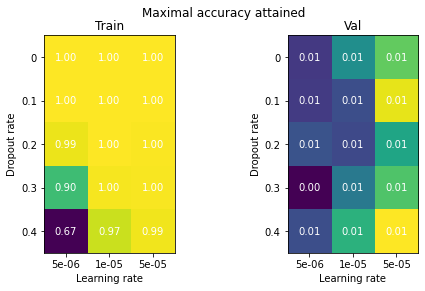

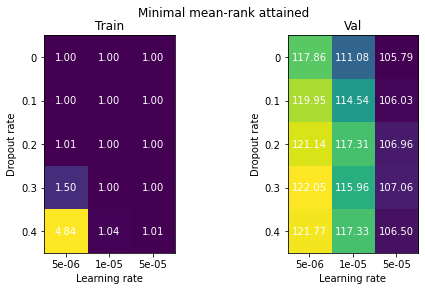

In [43]:
def plot_heatmap(train_vals_dict, val_vals_dict, title, reduce_fn=np.min):
    train_heatmap = np.zeros((len(dropout_vals), len(lr_vals)))
    val_heatmap = np.zeros((len(dropout_vals), len(lr_vals)))
    for xidx, dropout_val in enumerate(dropout_vals):
        for yidx, lr_val in enumerate(lr_vals):
            train_vals = train_vals_dict[(dropout_val, lr_val)]
            val_vals = val_vals_dict[(dropout_val, lr_val)]
            train_heatmap[xidx][yidx] = reduce_fn(train_vals)
            val_heatmap[xidx][yidx] = reduce_fn(val_vals)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(train_heatmap)
    axes[1].imshow(val_heatmap)
    for xidx, dropout_val in enumerate(dropout_vals):
        for yidx, lr_val in enumerate(lr_vals):
            _ = axes[0].text(yidx, xidx, '%.02f'%(train_heatmap[xidx, yidx]), ha='center', va='center', color='w')
            _ = axes[1].text(yidx, xidx, '%.02f'%(val_heatmap[xidx, yidx]), ha='center', va='center', color='w')
    for ax in axes:
        ax.set_xticks(np.arange(len(lr_vals)))
        ax.set_yticks(np.arange(len(dropout_vals)))
        ax.set_xticklabels(lr_vals)
        ax.set_yticklabels(dropout_vals)
        ax.set_xlabel('Learning rate')
        ax.set_ylabel('Dropout rate')
    axes[0].set_title('Train')
    axes[1].set_title('Val')
    fig.suptitle(title)
    fig.savefig(os.path.join(results_dir, 'heatmap__%s.png'%(title.split(' ')[1])))

min_fn = lambda x: np.min(local_avg(x, 100))
max_fn = lambda x: np.max(local_avg(x, 100))
plot_heatmap(train_loss_vals, val_loss_vals, 'Minimal loss attained', reduce_fn=min_fn)
plot_heatmap(train_acc_vals, val_acc_vals, 'Maximal accuracy attained', reduce_fn=max_fn)
plot_heatmap(train_rank_vals, val_rank_vals, 'Minimal mean-rank attained', reduce_fn=min_fn)